In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

Using TensorFlow backend.


# 加载数据集

猫狗大战：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import numpy as np
from tqdm import tqdm
import cv2

np.random.seed(2017)

n = 25000
X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range(n/2)):
    X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg' % i), (224, 224))
    X[i+n/2] = cv2.resize(cv2.imread('train/dog.%d.jpg' % i), (224, 224))

y[n/2:] = 1

100%|██████████| 12500/12500 [00:48<00:00, 257.96it/s]


# 分为训练集和验证集

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py


In [4]:
base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

In [5]:
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 训练模型

In [6]:
model.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_valid, y_valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 164s - loss: 0.1503 - acc: 0.9453 - val_loss: 0.0643 - val_acc: 0.9778
Epoch 2/5
20000/20000 [==============================] - 163s - loss: 0.0880 - acc: 0.9677 - val_loss: 0.0531 - val_acc: 0.9816
Epoch 3/5
20000/20000 [==============================] - 161s - loss: 0.0784 - acc: 0.9702 - val_loss: 0.0496 - val_acc: 0.9822
Epoch 4/5
20000/20000 [==============================] - 161s - loss: 0.0752 - acc: 0.9715 - val_loss: 0.0466 - val_acc: 0.9826
Epoch 5/5
20000/20000 [==============================] - 161s - loss: 0.0707 - acc: 0.9733 - val_loss: 0.0480 - val_acc: 0.9804


# 可视化模型

https://keras.io/visualization/

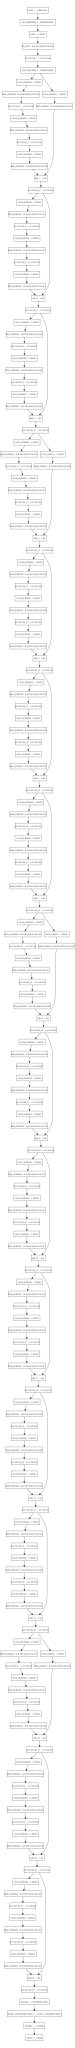

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [8]:
zip([x.name for x in model.layers], range(len(model.layers)))

[('input_1', 0),
 ('zero_padding2d_1', 1),
 ('conv1', 2),
 ('bn_conv1', 3),
 ('activation_1', 4),
 ('max_pooling2d_1', 5),
 ('res2a_branch2a', 6),
 ('bn2a_branch2a', 7),
 ('activation_2', 8),
 ('res2a_branch2b', 9),
 ('bn2a_branch2b', 10),
 ('activation_3', 11),
 ('res2a_branch2c', 12),
 ('res2a_branch1', 13),
 ('bn2a_branch2c', 14),
 ('bn2a_branch1', 15),
 ('add_1', 16),
 ('activation_4', 17),
 ('res2b_branch2a', 18),
 ('bn2b_branch2a', 19),
 ('activation_5', 20),
 ('res2b_branch2b', 21),
 ('bn2b_branch2b', 22),
 ('activation_6', 23),
 ('res2b_branch2c', 24),
 ('bn2b_branch2c', 25),
 ('add_2', 26),
 ('activation_7', 27),
 ('res2c_branch2a', 28),
 ('bn2c_branch2a', 29),
 ('activation_8', 30),
 ('res2c_branch2b', 31),
 ('bn2c_branch2b', 32),
 ('activation_9', 33),
 ('res2c_branch2c', 34),
 ('bn2c_branch2c', 35),
 ('add_3', 36),
 ('activation_10', 37),
 ('res3a_branch2a', 38),
 ('bn3a_branch2a', 39),
 ('activation_11', 40),
 ('res3a_branch2b', 41),
 ('bn3a_branch2b', 42),
 ('activation_1

In [9]:
weights = model.layers[177].get_weights()[0]
model2 = Model(model.input, [model.layers[172].output, model.output])

http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

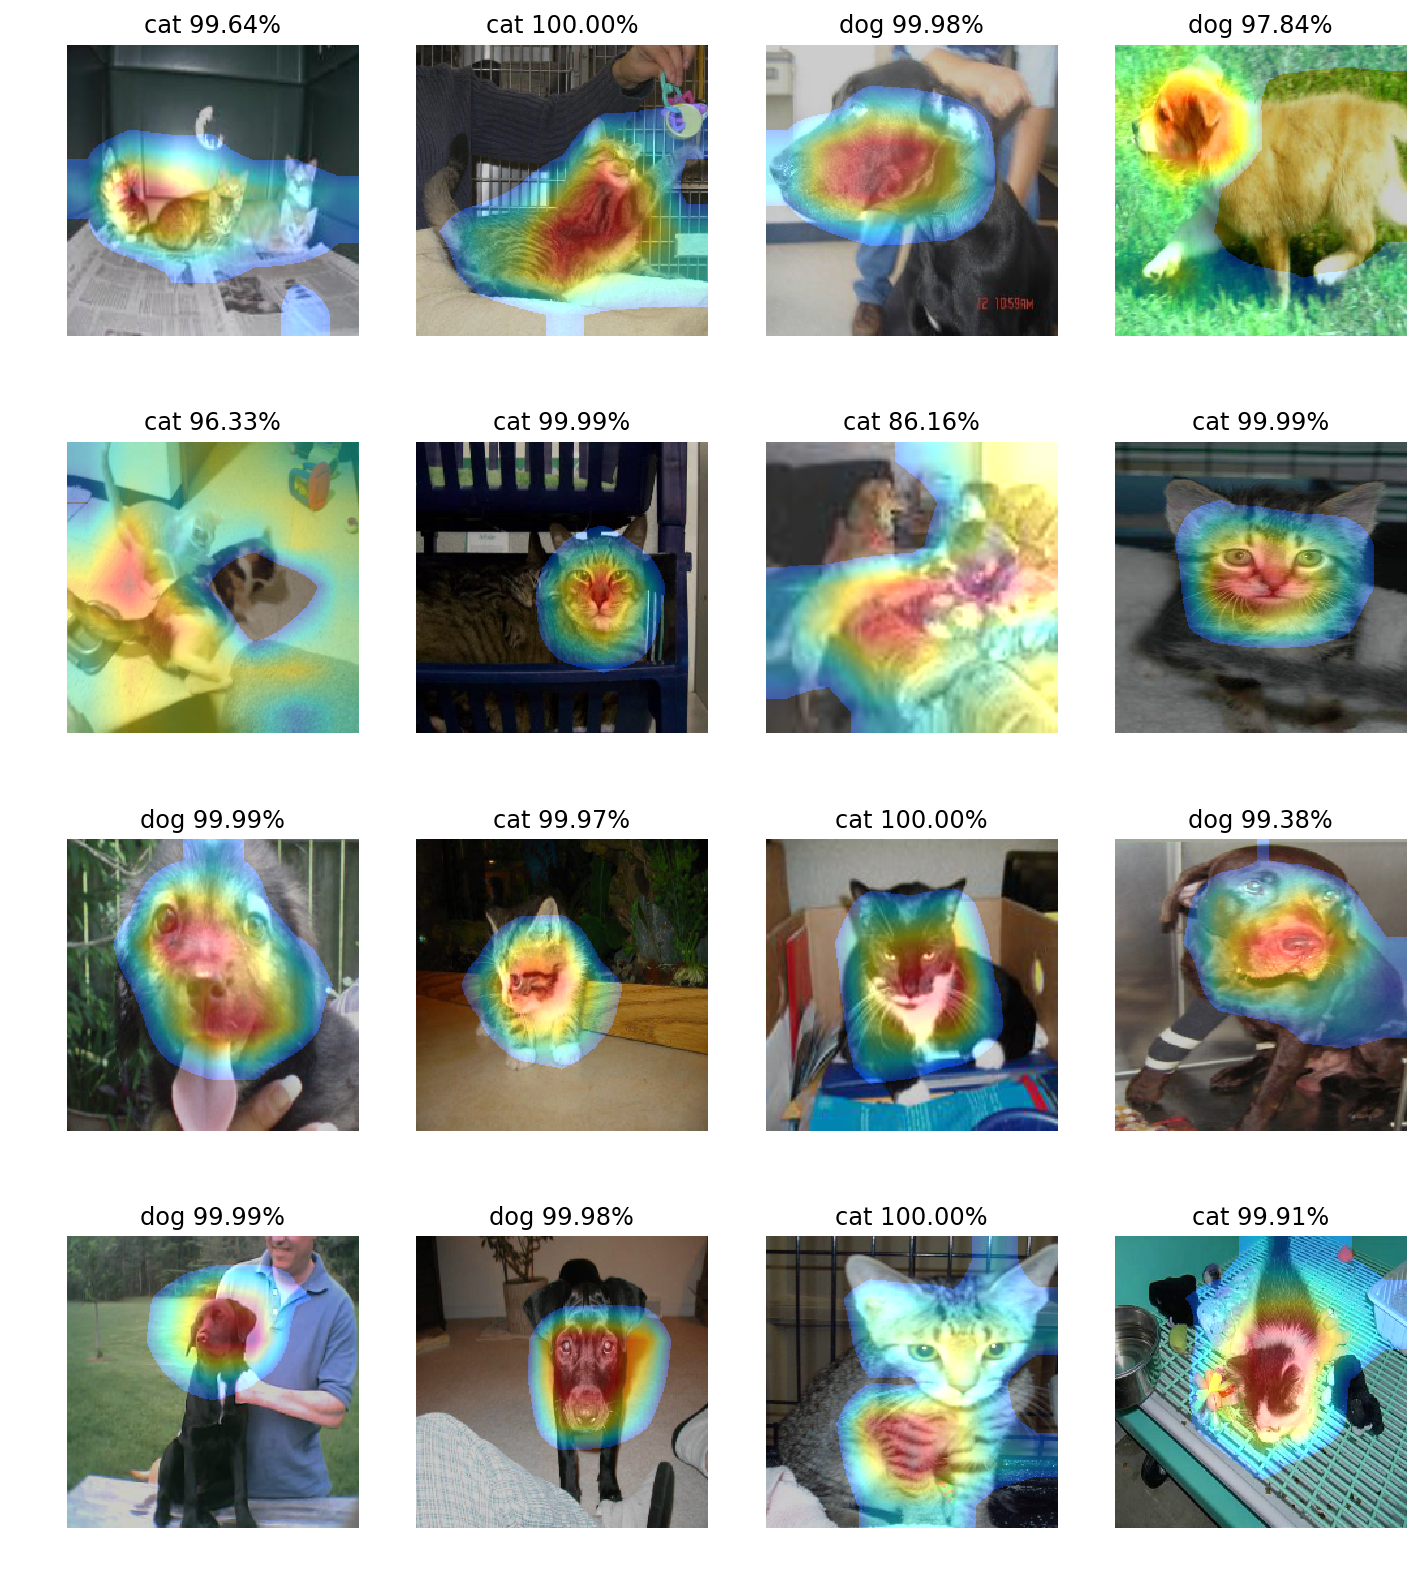

In [10]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('test/%d.jpg' % random.randint(1, 12500))
    img = cv2.resize(img, (224, 224))
    x = img.copy()
    x.astype(np.float32)
    out, prediction = model2.predict(np.expand_dims(x, axis=0))

    prediction = prediction[0]
    out = out[0]

    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))

    cam = (prediction - 0.5) * np.matmul(out, weights)
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8

    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out[:,:,::-1])

# Fine-tune

http://keras-cn.readthedocs.io/en/latest/blog/image_classification_using_very_little_data/

In [11]:
for layer in model.layers[140:]:
    layer.trainable = True

In [12]:
model.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_valid, y_valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 165s - loss: 0.0743 - acc: 0.9702 - val_loss: 0.0428 - val_acc: 0.9842
Epoch 2/5
20000/20000 [==============================] - 164s - loss: 0.0718 - acc: 0.9728 - val_loss: 0.0430 - val_acc: 0.9842
Epoch 3/5
20000/20000 [==============================] - 164s - loss: 0.0715 - acc: 0.9713 - val_loss: 0.0409 - val_acc: 0.9848
Epoch 4/5
20000/20000 [==============================] - 164s - loss: 0.0647 - acc: 0.9745 - val_loss: 0.0407 - val_acc: 0.9850
Epoch 5/5
20000/20000 [==============================] - 164s - loss: 0.0672 - acc: 0.9733 - val_loss: 0.0407 - val_acc: 0.9850
